In [9]:
import xscen as xs
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from xscen.config import CONFIG, load_config
import xscen as xs
from matplotlib import gridspec
from dask.distributed import Client
import xclim as xc
import dask
import numpy as np

load_config('paths_ESPO-G.yml', 'config_ESPO-G.yml', verbose=(__name__ == '__main__'), reset=True)
pcat = xs.ProjectCatalog(CONFIG['paths']['project_catalog'])
tdd = CONFIG['tdd']

2022-12-20 10:37:43,300 - xscen.config - INFO - Updated the config with paths_ESPO-G.yml.
2022-12-20 10:37:43,369 - xscen.config - INFO - Updated the config with config_ESPO-G.yml.


# domain


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


2022-12-20 10:34:10,935 - xscen.ensembles - INFO - Creating ensemble with 14 simulations and calculating ensemble_percentiles.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xclim/core/utils.py:461: RuntimeWarning: All-NaN slice encountered


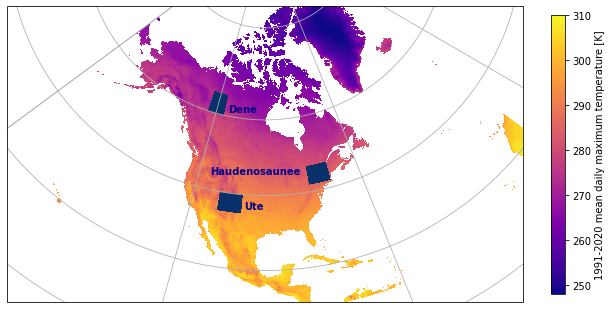

In [2]:
hau= pcat.search(processing_level='off-diag-scen-meas', domain ='Haudenosaunee', source='BCC-CSM2-MR',
                 experiment='ssp245' ).to_dask(**tdd)

ute= pcat.search(processing_level='off-diag-scen-meas', domain ='Ute', source='BCC-CSM2-MR',
                 experiment='ssp245' ).to_dask(**tdd)

dene= pcat.search(processing_level='off-diag-scen-meas', domain ='Dene', source='BCC-CSM2-MR',
                 experiment='ssp245' ).to_dask(**tdd)

# This is the map projection we want to plot *onto*
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)

# mean tx_mean
input_dict = pcat.search(processing_level='indicators', xrfreq='AS-JAN', variable='tx_mean', experiment='ssp370').to_dataset_dict()
input_dict = {i: ds.sel(time=slice('1991', '2020')).mean(dim='time') for i,ds in input_dict.items()}
tx_mean = xs.ensembles.ensemble_stats(
                    datasets=input_dict,
                    statistics={"ensemble_percentiles": {'split': False}},
                    common_attrs_only=False,
                ).tx_mean.sel(percentiles=50)

fig= plt.figure(figsize=(10,7))
p = tx_mean.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    cmap='plasma',add_colorbar=False,
    subplot_kws={"projection": map_proj},
)  # the plot's projection

cbar = plt.colorbar(p,fraction=0.025)
cbar.set_label('1991-2020 mean daily maximum temperature [K]')

hau.q01_tasmax.plot( transform=ccrs.PlateCarree(), subplot_kws={"projection": map_proj}, cmap='Blues',add_colorbar=False,vmin=-1000, vmax=1)
ute.q01_tasmax.plot(transform=ccrs.PlateCarree(), subplot_kws={"projection": map_proj}, cmap='Blues',add_colorbar=False,vmin=-1000, vmax=1)
dene.q01_tasmax.plot( transform=ccrs.PlateCarree(), subplot_kws={"projection": map_proj},cmap='Blues',add_colorbar=False,vmin=-1000, vmax=1)


ax = plt.gca()
ax.text(-114,61,'Dene', color='darkblue',weight='bold',transform=ccrs.PlateCarree())
ax.text(-102,36,'Ute', color='darkblue',weight='bold',transform=ccrs.PlateCarree())
ax.text(-116,44,'Haudenosaunee', color='darkblue',weight='bold',transform=ccrs.PlateCarree())
ax.gridlines()
ax.set_extent([-160, -30, 5, 75])
plt.savefig(f"{CONFIG['paths']['figures']}domain.png")


# maps

In [3]:
#load all properties from ref, sim, scen

def maps(option_id, option_region, option_var):
    ref = pcat.search( processing_level=['diag-ref-prop*', 'diag_ref_prop'], domain=option_region).to_dask()
    sim = pcat.search(id= option_id, processing_level='diag-sim-prop*', domain=option_region).to_dask()
    scen = pcat.search(id= option_id, processing_level='diag-scen-prop*', domain=option_region).to_dask()
    #get meas
    meas_sim = pcat.search(id=option_id, processing_level='diag-sim-meas*', domain=option_region).to_dask()
    meas_scen = pcat.search(id=option_id, processing_level='diag-scen-meas*', domain=option_region).to_dask()


    prop_sim = sim[option_var]
    prop_ref = ref[option_var]
    prop_scen = scen[option_var]
    meas_scen_prop = meas_scen[option_var]
    meas_sim_prop = meas_sim[option_var]

    #colormap
    maxi_prop = max(prop_ref.max().values, prop_scen.max().values, prop_sim.max().values)
    mini_prop = min(prop_ref.min().values, prop_scen.min().values, prop_sim.min().values)
    maxi_meas = max(abs(meas_scen_prop).max().values, abs(meas_sim_prop).max().values)
    cmap='viridis_r' if 'standard_name' in prop_sim and   prop_sim.attrs['standard_name']== 'precipitation_flux' else 'plasma'
    cmap_meas ='BrBG' if 'standard_name' in prop_sim and prop_sim.attrs['standard_name']== 'precipitation_flux' else 'coolwarm'

    long_name=prop_sim.attrs['long_name']


    #
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(4, 3)
    ax0= fig.add_subplot(gs[1:3,0])
    ax1= fig.add_subplot(gs[:2,1])
    ax2= fig.add_subplot(gs[:2,2])
    ax3= fig.add_subplot(gs[2:,1])
    ax4= fig.add_subplot(gs[2:,2])


    prop_ref.plot(ax=ax0, cmap=cmap, vmin=mini_prop,vmax=maxi_prop)
    prop_sim.plot( cmap=cmap, vmin=mini_prop,vmax=maxi_prop, ax=ax1)
    meas_sim_prop.plot( cmap=cmap_meas, vmin=-maxi_meas,vmax=maxi_meas, ax=ax2)
    prop_scen.plot( cmap=cmap, vmin=mini_prop,vmax=maxi_prop, ax=ax3)
    meas_scen_prop.plot( cmap=cmap_meas, vmin=-maxi_meas,vmax=maxi_meas, ax=ax4)

    # for ax in [ax0,ax1,ax2,ax3,ax4]:
    #     ax.set_ylabel(fontsize=10)
    #     ax.set_xlabel(fontsize=10)

    ax0.set_title('a) Reference property')
    ax1.set_title('b) Simulation property')
    ax2.set_title('c) Simulation measure')
    ax3.set_title('d) Scenario property')
    ax4.set_title('e) Scenario measure')
    fig.tight_layout()

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/core.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


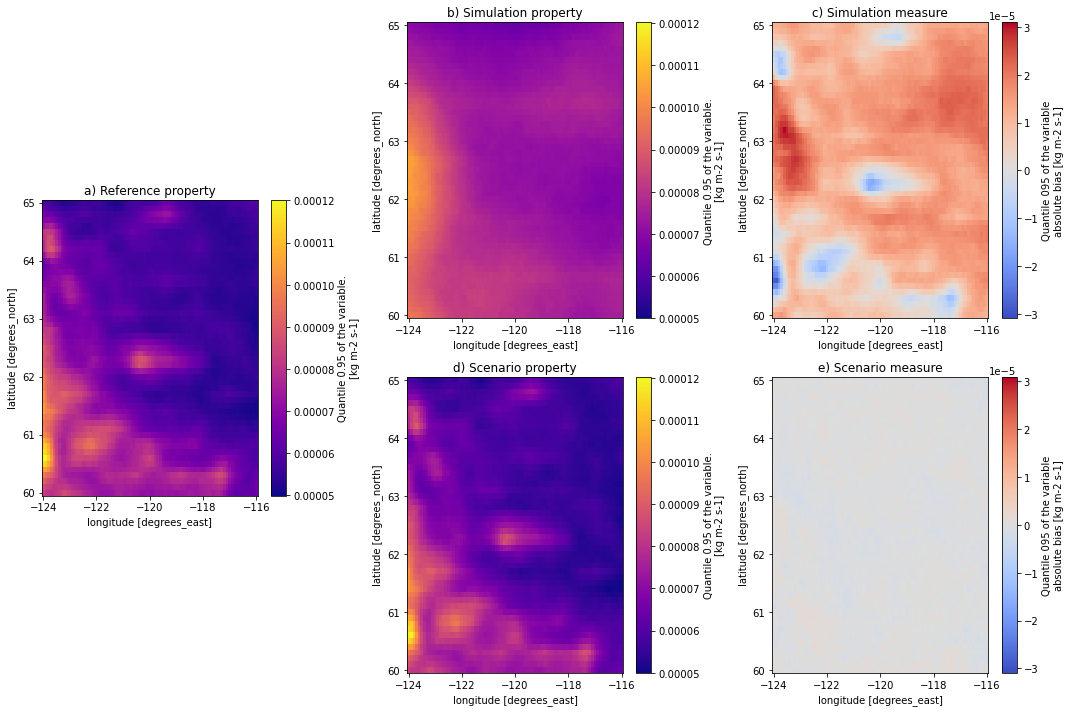

In [4]:
option_id = 'CMIP6_ScenarioMIP_DKRZ_MPI-ESM1-2-HR_ssp245_r1i1p1f1_global'
option_region = 'Dene'
option_var = 'q95_pr'
maps(option_id=option_id, option_region=option_region, option_var=option_var)
plt.savefig(f"{CONFIG['paths']['figures']}pr.png")


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/core.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


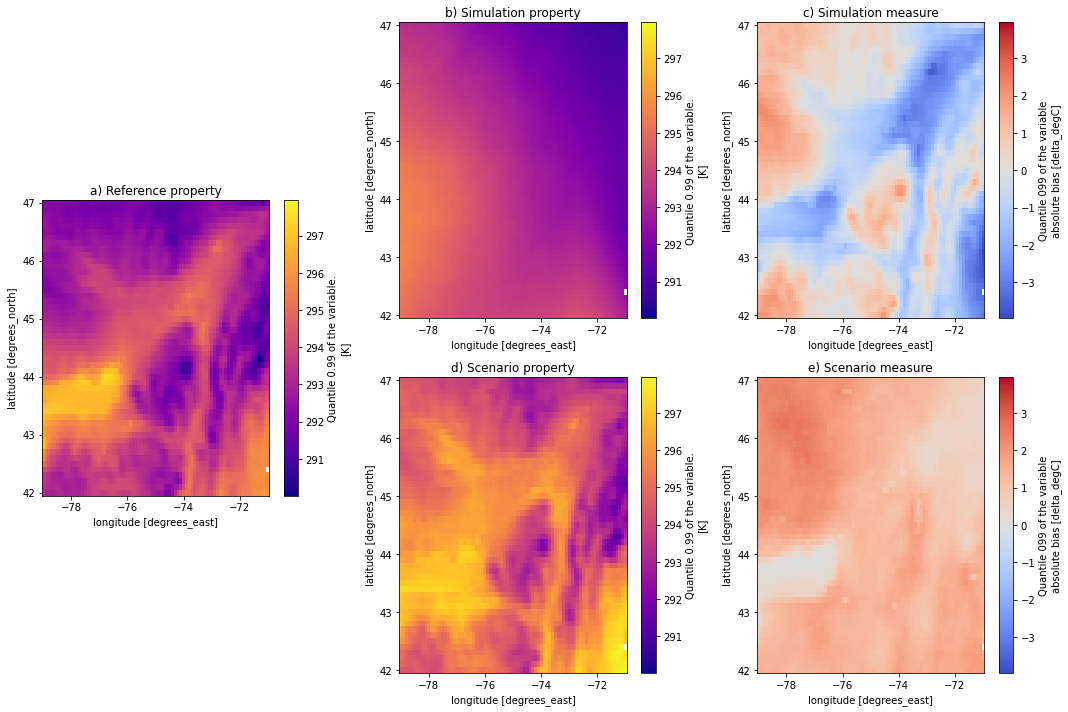

In [5]:

option_id = 'CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp245_r1i1p1f1_global'
option_region = 'Haudenosaunee'
option_var = 'q99_tasmin'
maps(option_id=option_id, option_region=option_region, option_var=option_var)
plt.savefig(f"{CONFIG['paths']['figures']}tasmin.png")


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/core.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


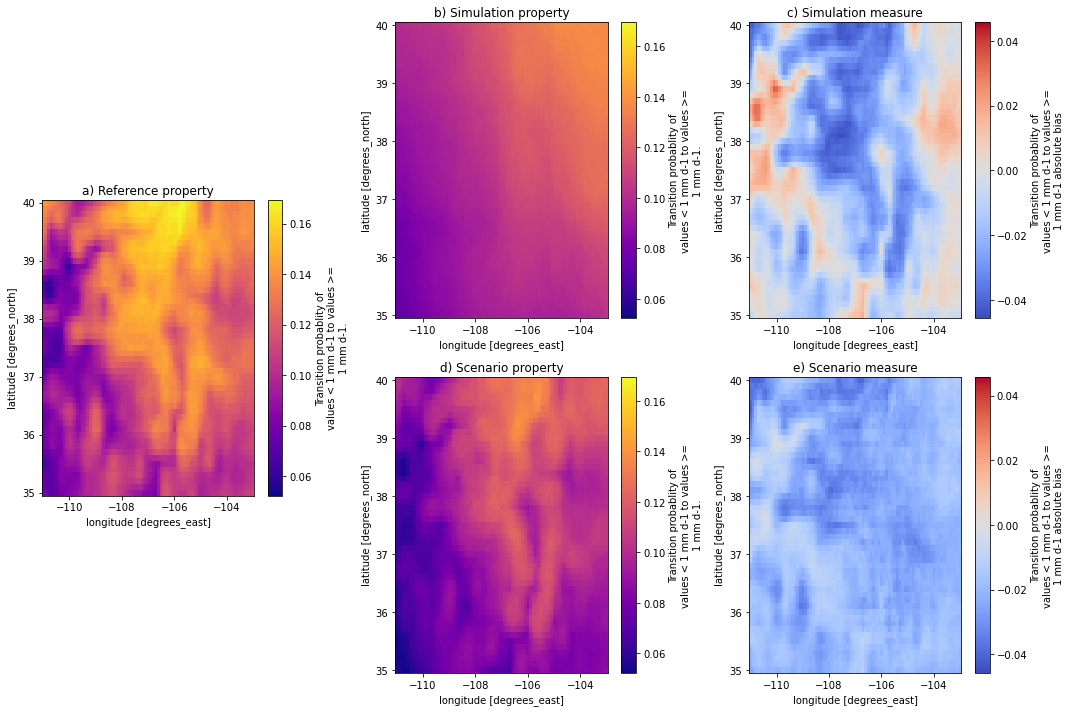

In [6]:
option_id ='CMIP6_ScenarioMIP_MPI-M_MPI-ESM1-2-LR_ssp370_r1i1p1f1_global'
option_region = 'Ute'
option_var = 'dry_wet_transition'
maps(option_id=option_id, option_region=option_region, option_var=option_var)

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/core.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


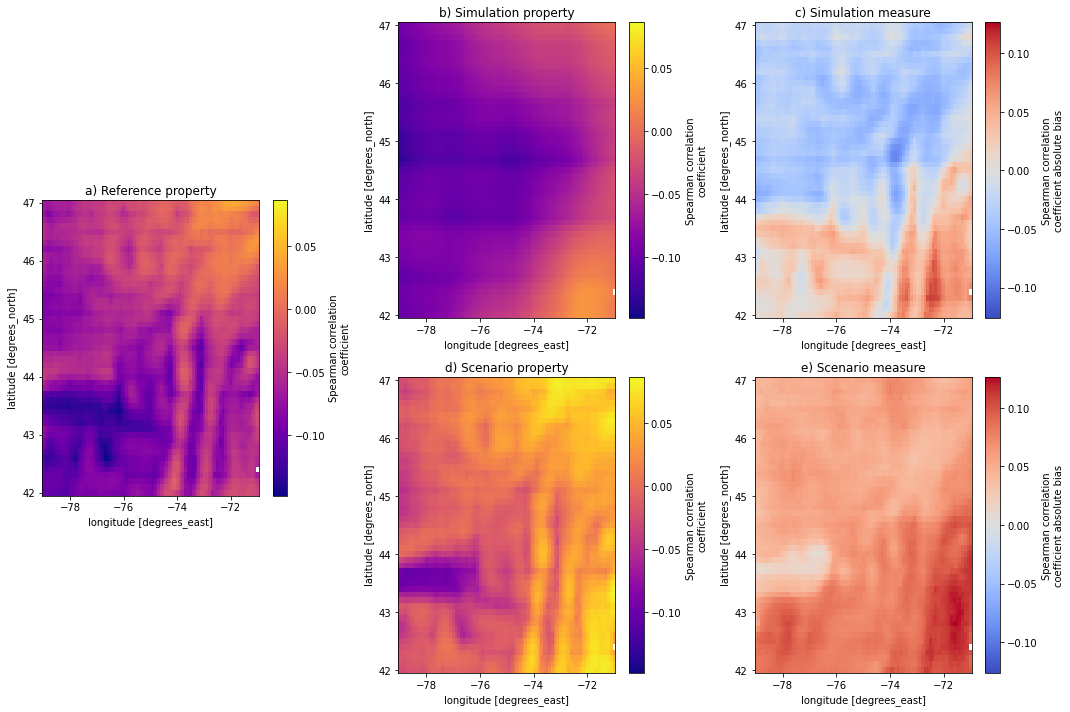

In [7]:
option_id ='CMIP6_ScenarioMIP_NIMS-KMA_KACE-1-0-G_ssp245_r1i1p1f1_global'
option_region = 'Haudenosaunee'
option_var = 'corr_tasmax_pr'
maps(option_id=option_id, option_region=option_region, option_var=option_var)

# improved

In [10]:
# get mean IMP
mean=[]
for domain in ['Haudenosaunee', 'Ute', 'Dene']:
    dict_hm = pcat.search(processing_level='diag-improved', domain= domain).to_dataset_dict()
    merge={}
    for name, ds in dict_hm.items():
        out = ds.expand_dims(dim ={'datasets':[f"{ds.attrs['cat:source']}_{ds.attrs['cat:experiment']}"]})
        merge[f"{out.attrs['cat:source']}_{out.attrs['cat:experiment']}"]=out
    merge= [merge[k] for k in sorted(merge.keys())[::-1]]
    ds_merge = xr.concat(merge, dim='datasets')
    ds_merge['datasets']= ds_merge['datasets'].astype(str)
    plt.figure(figsize=(10,10))
    ds_merge['improved_grid_points']= ds_merge['improved_grid_points']*100
    mean.append(ds_merge.sel(properties=['decorrelation_length_tasmin_0.5','decorrelation_length_tasmax_0.5','decorrelation_length_pr_0.5']).improved_grid_points.mean().values)
print(mean)
print(np.mean(mean))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


[array(80.67883085), array(91.83525262), array(82.45466911)]
84.98958419479483


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


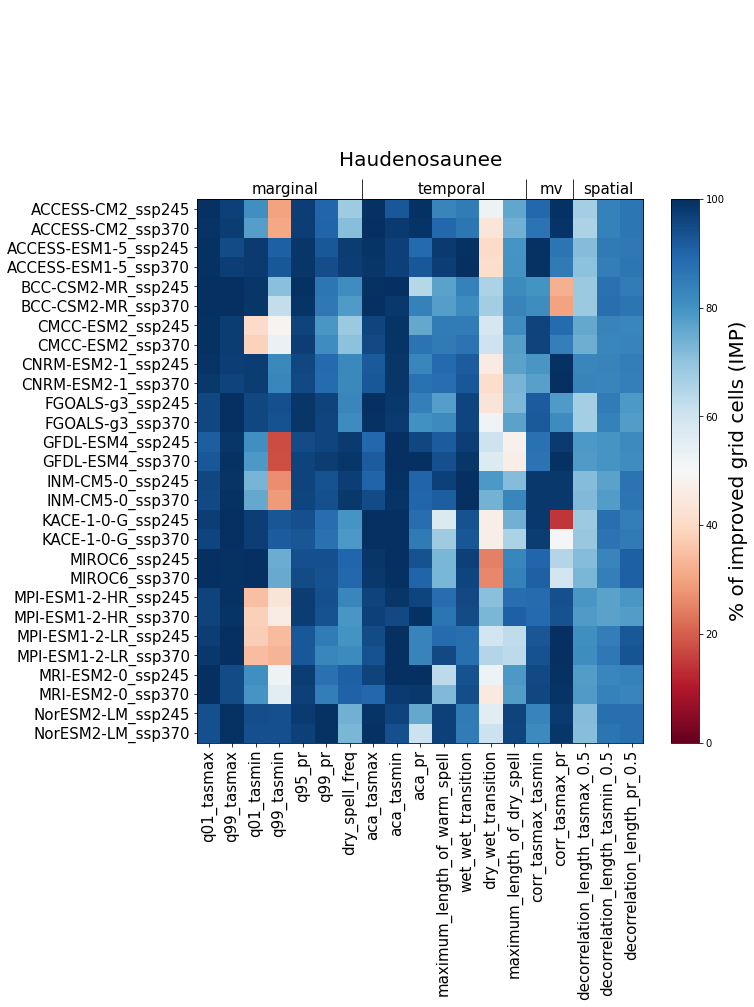

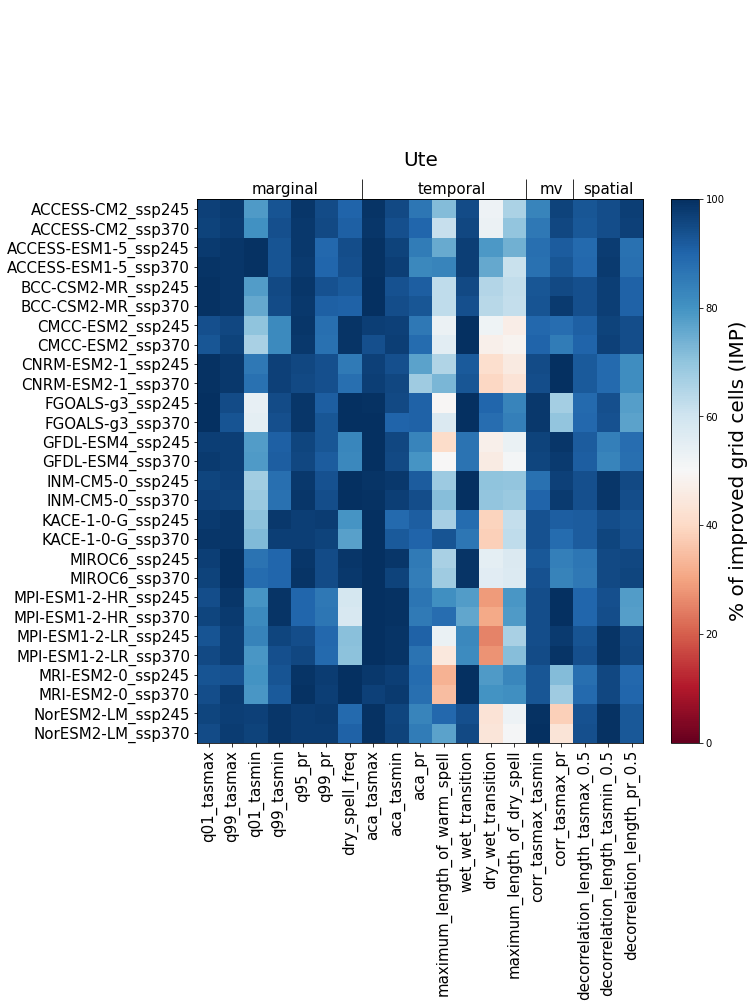

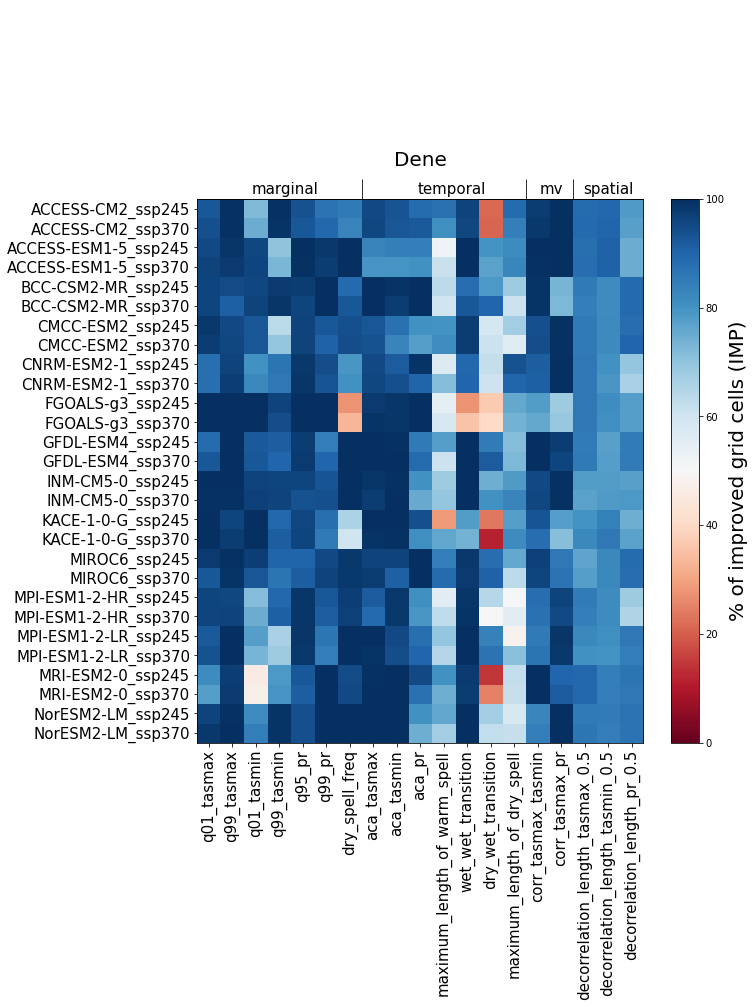

In [11]:
order = [
        'q01_tasmax', 'q99_tasmax', 'q01_tasmin','q99_tasmin', 'q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'maximum_length_of_warm_spell','wet_wet_transition', 'dry_wet_transition', 'maximum_length_of_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        'decorrelation_length_tasmax_0.5', 'decorrelation_length_tasmin_0.5','decorrelation_length_pr_0.5'
        ]
ds_merge.sel(properties=order)
for domain in ['Haudenosaunee', 'Ute', 'Dene']:
    dict_hm = pcat.search(processing_level='diag-improved', domain= domain).to_dataset_dict()
    merge={}
    for name, ds in dict_hm.items():
        out = ds.expand_dims(dim ={'datasets':[f"{ds.attrs['cat:source']}_{ds.attrs['cat:experiment']}"]})
        merge[f"{out.attrs['cat:source']}_{out.attrs['cat:experiment']}"]=out
    merge= [merge[k] for k in sorted(merge.keys())[::-1]]
    ds_merge = xr.concat(merge, dim='datasets')
    ds_merge['datasets']= ds_merge['datasets'].astype(str)
    plt.figure(figsize=(10,10))
    ds_merge['improved_grid_points']= ds_merge['improved_grid_points']*100
    
    heatmap = ds_merge.sel(properties=order).improved_grid_points.plot.imshow(add_colorbar=True,vmin=0, cmap = 'RdBu',cbar_kwargs={
                          "orientation": "vertical",
                         })
    heatmap.colorbar.set_label('% of improved grid cells (IMP)', size=20)

    plt.xticks( rotation=90, size=15)
    plt.yticks(size=15)
    plt.xlabel('')
    plt.ylabel('')
    y=1.13
    plt.annotate(r"marginal",fontsize=15,xy=(0.35, y), xycoords='figure fraction')
    plt.annotate(r"temporal",fontsize=15,xy=(0.58, y), xycoords='figure fraction')
    plt.annotate(r"mv",fontsize=15,xy=(0.75, y), xycoords='figure fraction')
    plt.annotate(r"spatial",fontsize=15,xy=(0.81, y), xycoords='figure fraction')
    ax2 = plt.gca().secondary_xaxis('top')
    ax2.tick_params(axis='x',length=20)
    ax2.set_xticks([6.5,13.5, 15.5])
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.title(domain, y=1.05, fontsize=20)
    plt.savefig(f"{CONFIG['paths']['figures']}{domain}.png")

    

# correlogram

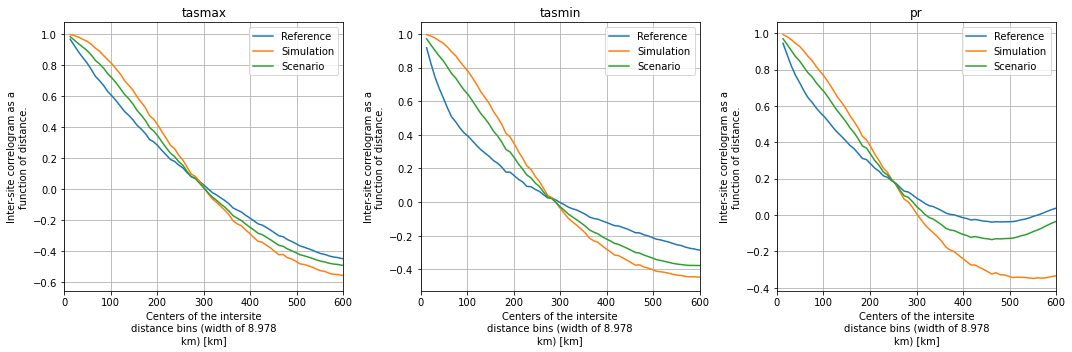

In [12]:
c_ref = pcat.search(processing_level='correlogram-ref', domain= 'Ute' ).to_dask()
c_sim = pcat.search(processing_level='correlogram-sim',id ='CMIP6_ScenarioMIP_MRI_MRI-ESM2-0_ssp370_r1i1p1f1_global',  domain= 'Ute' ).to_dask()
c_scen = pcat.search(processing_level='correlogram-scen',id ='CMIP6_ScenarioMIP_MRI_MRI-ESM2-0_ssp370_r1i1p1f1_global', domain= 'Ute' ).to_dask()

fig, axs = plt.subplots(1,3, figsize=(15,5))
for i,var in enumerate(['tasmax', 'tasmin', 'pr']):
    ax =axs[i]
    c_ref[f"correlogram_{var}"].plot(label='Reference',ax=ax)
    c_sim[f"correlogram_{var}"].plot(label='Simulation',ax=ax)
    c_scen[f"correlogram_{var}"].plot(label='Scenario',ax=ax)
    ax.set_xlim(0,600)
    ax.legend()
    ax.grid()
    ax.set_title(var)
fig.tight_layout()
plt.savefig(f"{CONFIG['paths']['figures']}corr.png")


# Q-Q

In [108]:
with (Client(n_workers=2, threads_per_worker=5, memory_limit="25GB",dashboard_address= 6786,local_directory= '/exec/jlavoie/tmp_ic6/'),
     ):

    ref= pcat.search(processing_level ='extracted',domain='middle_nodup', calendar='default').to_dask()
    ref = xs.utils.unstack_fill_nan(ref)
    dom_dict= CONFIG['off-diag']['domains']['Haudenosaunee']
    ref = xs.extract.clisops_subset(ref.chunk({'time': -1}), dom_dict).sel(time=slice('1991','2020')).chunk(dict(lat=-1, lon=-1))
    sim= pcat.search(processing_level ='regridded',domain='middle', id = 'CMIP6_ScenarioMIP_INM_INM-CM5-0_ssp370_r1i1p1f1_global').to_dask()
    sim = xs.utils.unstack_fill_nan(sim)
    sim = xs.extract.clisops_subset(sim.chunk({'time': -1}), dom_dict).sel(time=slice('1991','2020')).chunk(dict(lat=-1, lon=-1))
    
    
    scen= pcat.search(processing_level ='final',domain='middle', id = 'CMIP6_ScenarioMIP_INM_INM-CM5-0_ssp370_r1i1p1f1_global').to_dask()
    scen = xs.extract.clisops_subset(scen.chunk({'time': -1}), dom_dict).sel(time=slice('1991','2020')).chunk(dict(lat=-1, lon=-1))
    
    
    quantiles = xc.sdba.utils.equally_spaced_nodes(50)
    ref_q={}
    sim_q={}
    scen_q={}
    for var in [ 'pr']:
        if var == 'pr':
            ref['pr']=ref.pr.where(ref.pr> 1/86400)
            sim['pr']=sim.pr.where(sim.pr> 1/86400)
            scen['pr']=scen.pr.where(scen.pr> 1/86400)
        ref_q[var]=[]
        sim_q[var]=[]
        scen_q[var]=[]
        for q in quantiles:
            print(q)
            s_q=float(sim[var].quantile(q,skipna=True).values)
            print(s_q)
            ref_q[var].append(float(ref[var].quantile(q,skipna=True).values))
            sim_q[var].append(s_q)
            scen_q[var].append(float(scen[var].quantile(q,skipna=True).values))
print(ref_q)
print(sim_q)
print(scen_q)

2022-12-06 09:05:39,459 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_nodup_250x1700.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/c

2022-12-06 09:05:49,201 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

0.01
1.1887126829606132e-05
0.03
1.2533891576822497e-05
0.05
1.3210094812166062e-05
0.06999999999999999
1.3920543051426647e-05
0.09
1.4667754521724417e-05
0.11
1.5448523736267817e-05
0.13
1.6265097656287253e-05
0.15000000000000002
1.7120981283369474e-05
0.17
1.8028298654826358e-05
0.19
1.8986992399732118e-05
0.21000000000000002
1.9996577975689434e-05
0.23
2.1061851930426202e-05
0.25
2.2184516637935303e-05
0.27
2.3366860823443858e-05
0.29000000000000004
2.4615865186206065e-05
0.31
2.5942574211512692e-05
0.33
2.7342371031409132e-05
0.35000000000000003
2.881329746742268e-05
0.37
3.037352507817559e-05
0.39
3.2038031349657103e-05
0.41000000000000003
3.381078546226491e-05
0.43
3.570087072148454e-05
0.45
3.771573392441496e-05
0.47000000000000003
3.987619114923291e-05
0.49
4.219662878313102e-05
0.51
4.4673773445538245e-05
0.53
4.731887031084625e-05
0.55
5.0155402277596295e-05
0.5700000000000001
5.3190998660284104e-05
0.59
5.647860962199047e-05
0.61
5.999830169457707e-05
0.63
6.381009312462994e

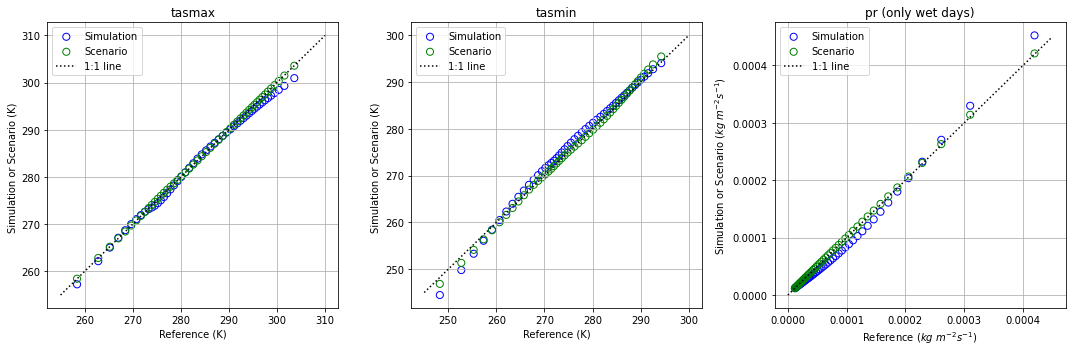

In [24]:
ref_q={'tasmax': [258.43347168, 262.84265137, 265.24993896, 267.01174927, 268.45178223, 269.69110107, 270.76800964, 271.71435547, 272.55310059, 273.31137085, 273.98266602, 274.61264038, 275.23013306, 275.85906982, 276.50180054, 277.16711426, 277.85913086, 278.57788086, 279.32489014, 280.11358643, 280.9319458, 281.76629639, 282.61663818, 283.48498535, 284.36993408, 285.27313232, 286.16455078, 287.03427124, 287.88024902, 288.71679688, 289.5328064, 290.31237793, 291.05587769, 291.75973511, 292.42855835, 293.06392487, 293.66369629, 294.23651123, 294.79046722, 295.33004761, 295.86669922, 296.40576172, 296.95907593, 297.53204346, 298.13040161, 298.77786255, 299.5055542, 300.37490845, 301.54400635, 303.60809326], 'tasmin': [248.24847412109375, 252.7071990966797, 255.28163146972656, 257.3421325683594, 259.0981295776367, 260.6628723144531, 262.0649108886719, 263.3668212890625, 264.5862731933594, 265.7155456542969, 266.779541015625, 267.76922607421875, 268.671630859375, 269.472900390625, 270.1803283691406, 270.82061767578125, 271.40911865234375, 271.9631652832031, 272.5046691894531, 273.0483703613281, 273.6011962890625, 274.17535400390625, 274.8084716796875, 275.500244140625, 276.232666015625, 276.9873046875, 277.757080078125, 278.5330505371094, 279.3125, 280.0951232910156, 280.868896484375, 281.6219177246094, 282.3416748046875, 283.0276184082031, 283.6765441894531, 284.29595947265625, 284.8918762207031, 285.4709777832031, 286.0401306152344, 286.6043701171875, 287.164306640625, 287.7200927734375, 288.2729187011719, 288.8406066894531, 289.43194580078125, 290.068359375, 290.76434326171875, 291.56500244140625, 292.5841369628906, 294.28662109375], 'pr': [1.1956371054111514e-05, 1.275403246836504e-05, 1.3595929885923397e-05, 1.448706734663574e-05, 1.543098005640786e-05, 1.6428528506367003e-05, 1.7483855117461644e-05, 1.8599030227051117e-05, 1.9780085494858213e-05, 2.102443431795109e-05, 2.2341913791024126e-05, 2.3735963623039424e-05, 2.5209008526871912e-05, 2.676733311091084e-05, 2.8411202947609127e-05, 3.015544825757388e-05, 3.199507111276034e-05, 3.393075567146298e-05, 3.596914393710904e-05, 3.81202444259543e-05, 4.039680788991973e-05, 4.281265486497435e-05, 4.535885818768293e-05, 4.806150172953494e-05, 5.093119034427218e-05, 5.398083885665983e-05, 5.722356218029745e-05, 6.068774382583797e-05, 6.434101829654538e-05, 6.824042066000402e-05, 7.236704550450668e-05, 7.675145752727985e-05, 8.141432044794783e-05, 8.642234024591744e-05, 9.181038869428449e-05, 9.764148853719234e-05, 0.0001039611452142708, 0.00011087416714872234, 0.00011841946979984641, 0.00012665266258409246, 0.0001357853616354987, 0.0001460198254790157, 0.0001575677364598959, 0.00017077290976885706, 0.00018630952399689704, 0.00020506565197138111, 0.00022870191460242504, 0.00026099951355718076, 0.00031013329862616956, 0.0004196265665814274]}
sim_q={'tasmax': [257.26226776, 262.16369629, 265.04077148, 267.13336182, 268.72732544, 270.01977539, 271.07748413, 271.94155884, 272.64007568, 273.18236725, 273.53268433, 273.92871094, 274.45346069, 275.06869507, 275.76257324, 276.534729, 277.3677063, 278.22302246, 279.10067749, 280.01867676, 280.97396851, 281.94250488, 282.91970825, 283.8861084, 284.79605103, 285.65481567, 286.46994019, 287.24411011, 287.99249268, 288.70617676, 289.40960693, 290.09976196, 290.74649048, 291.36260986, 291.93414307, 292.47143555, 292.99490356, 293.50152588, 293.98504639, 294.45550537, 294.91314697, 295.35894775, 295.80776978, 296.26287842, 296.72344971, 297.22338867, 297.7911377, 298.44882202, 299.30368042, 300.95004303], 'tasmin': [244.46383666992188, 249.80029296875, 253.294677734375, 256.0664367675781, 258.42376708984375, 260.49169921875, 262.32470703125, 263.97906494140625, 265.46832275390625, 266.80633544921875, 268.0258483886719, 269.1261291503906, 270.0998840332031, 270.9431457519531, 271.646240234375, 272.2143249511719, 272.7005920410156, 273.187744140625, 273.7205087280273, 274.31854248046875, 274.9613342285156, 275.6300048828125, 276.3241882324219, 277.0516357421875, 277.7929992675781, 278.53076171875, 279.2662048339844, 279.96356201171875, 280.64520263671875, 281.3094787597656, 281.9645080566406, 282.598388671875, 283.216796875, 283.8310852050781, 284.42626953125, 285.00323486328125, 285.56964111328125, 286.1213684082031, 286.656982421875, 287.19049072265625, 287.71923828125, 288.2524719238281, 288.8021545410156, 289.3553161621094, 289.9299621582031, 290.5283203125, 291.1708679199219, 291.9042053222656, 292.76019287109375, 294.0564880371094], 'pr': [1.1887126829606132e-05, 1.2533891576822497e-05, 1.3210094812166062e-05, 1.3920543051426647e-05, 1.4667754521724417e-05, 1.5448523736267817e-05, 1.6265097656287253e-05, 1.7120981283369474e-05, 1.8028298654826358e-05, 1.8986992399732118e-05, 1.9996577975689434e-05, 2.1061851930426202e-05, 2.2184516637935303e-05, 2.3366860823443858e-05, 2.4615865186206065e-05, 2.5942574211512692e-05, 2.7342371031409132e-05, 2.881329746742268e-05, 3.037352507817559e-05, 3.2038031349657103e-05, 3.381078546226491e-05, 3.570087072148454e-05, 3.771573392441496e-05, 3.987619114923291e-05, 4.219662878313102e-05, 4.4673773445538245e-05, 4.731887031084625e-05, 5.0155402277596295e-05, 5.3190998660284104e-05, 5.647860962199047e-05, 5.999830169457707e-05, 6.381009312462994e-05, 6.797099922550842e-05, 7.250491602462717e-05, 7.74375772016356e-05, 8.280988600745333e-05, 8.873009974195157e-05, 9.529613089398481e-05, 0.00010268906240526121, 0.00011101292024250141, 0.00012061566842021417, 0.00013183725401177076, 0.0001450733208912424, 0.00016100573091534895, 0.00018021500727627426, 0.00020358899884740826, 0.0002323109220014885, 0.00027050367061747297, 0.0003297651413595303, 0.0004524225753266362]}
scen_q={'tasmax': [258.45437622, 262.85024933, 265.23431396, 266.99688721, 268.45480347, 269.71459961, 270.80905151, 271.77374268, 272.6401062, 273.40979004, 274.09829712, 274.74569702, 275.38574219, 276.0267334, 276.66690063, 277.30529785, 277.96011353, 278.64346313, 279.37191772, 280.15029907, 280.96673584, 281.80322266, 282.64877319, 283.51647949, 284.39944458, 285.29705811, 286.17993164, 287.04336548, 287.88616943, 288.71661377, 289.53396606, 290.31185913, 291.05554199, 291.7545166, 292.41705322, 293.04956055, 293.64788818, 294.21871948, 294.77139282, 295.31219482, 295.84753418, 296.38677979, 296.93615723, 297.50613403, 298.10198975, 298.74685669, 299.46939087, 300.33370972, 301.49105835, 303.58236694], 'tasmin': [246.848388671875, 251.3385467529297, 254.12014770507812, 256.3755187988281, 258.30548095703125, 260.0230712890625, 261.60455322265625, 263.0862121582031, 264.4793395996094, 265.80682373046875, 267.01531982421875, 268.0326232910156, 268.8780746459961, 269.6083679199219, 270.26556396484375, 270.8779602050781, 271.4643859863281, 272.0392761230469, 272.60528564453125, 273.1696472167969, 273.7409973144531, 274.325927734375, 274.92889404296875, 275.5496520996094, 276.20068359375, 276.87744140625, 277.5774841308594, 278.3052673339844, 279.0513610839844, 279.80224609375, 280.5501708984375, 281.29681396484375, 282.0399475097656, 282.7775573730469, 283.5037841796875, 284.2072448730469, 284.8935241699219, 285.5668029785156, 286.22467041015625, 286.883544921875, 287.5379943847656, 288.1953430175781, 288.86090087890625, 289.54351806640625, 290.2510986328125, 291.0010681152344, 291.80389404296875, 292.6987609863281, 293.79412841796875, 295.4857177734375], 'pr': [1.1945056285185273e-05, 1.273044563276926e-05, 1.3582959036284592e-05, 1.450608153390931e-05, 1.5488414355786517e-05, 1.6529860149603338e-05, 1.762525746016763e-05, 1.878330294857733e-05, 1.9998909629066474e-05, 2.1291357406880706e-05, 2.265760114823934e-05, 2.4099524089251646e-05, 2.5619665393605828e-05, 2.7213123830733823e-05, 2.8893246126244778e-05, 3.067010809900239e-05, 3.252989336033352e-05, 3.449311770964414e-05, 3.656567423604429e-05, 3.8750275562051686e-05, 4.1063291573664176e-05, 4.3500458559719846e-05, 4.607231385307387e-05, 4.8800240620039403e-05, 5.1708258979488164e-05, 5.480014093336649e-05, 5.807144611026161e-05, 6.153212161734702e-05, 6.519899994600564e-05, 6.908639508765191e-05, 7.322399236727502e-05, 7.76258803671226e-05, 8.230131643358619e-05, 8.730049623409286e-05, 9.268777881516147e-05, 9.852892049821098e-05, 0.00010492011992027983, 0.00011186665506102145, 0.00011941456323256715, 0.00012774328992236407, 0.00013691018277313562, 0.00014717182901222262, 0.0001587210310390219, 0.00017188284255098552, 0.00018746137560810895, 0.00020645754295401276, 0.0002302687498740852, 0.0002629997034091511, 0.0003140762296970929, 0.0004209034377709031]}

fig, axs = plt.subplots(1,3, figsize=(15,5))

for var in ['tasmax']:
    axs[0].scatter(ref_q[var], sim_q[var],  s=50,label='Simulation', facecolors='none', edgecolors='blue' )
    axs[0].scatter(ref_q[var], scen_q[var],s=50, label='Scenario', facecolors='none', edgecolors='green' )
    axs[0].plot([255,310],[255,310], 'k:', label='1:1 line')
    axs[0].legend()
    axs[0].set_ylabel('Simulation or Scenario (K) ')
    axs[0].set_xlabel('Reference (K)')
    axs[0].set_title(var)
    axs[0].grid()
for var in ['tasmin']:
    axs[1].scatter(ref_q[var], sim_q[var],  s=50,label='Simulation', facecolors='none', edgecolors='blue' )
    axs[1].scatter(ref_q[var], scen_q[var],s=50, label='Scenario', facecolors='none', edgecolors='green' )
    axs[1].plot([245,300],[245,300], 'k:', label='1:1 line')
    axs[1].legend()
    axs[1].set_ylabel('Simulation or Scenario (K) ')
    axs[1].set_xlabel('Reference (K)')
    axs[1].set_title(var)
    axs[1].grid()

for var in [ 'pr']:
    axs[2].scatter(ref_q[var], sim_q[var],  s=50,label='Simulation', facecolors='none', edgecolors='blue' )
    axs[2].scatter(ref_q[var], scen_q[var],s=50, label='Scenario', facecolors='none', edgecolors='green' )
    axs[2].plot([0,0.00045],[0,0.00045], 'k:', label='1:1 line')
    axs[2].legend()
    axs[2].set_ylabel(r'Simulation or Scenario ($kg$ $m^{-2} s^{-1}$) ')
    axs[2].set_xlabel(r'Reference ($kg$ $m^{-2} s^{-1}$)')
    axs[2].set_title(f"{var} (only wet days)")
    axs[2].grid()
fig.tight_layout()
plt.savefig(f"{CONFIG['paths']['figures']}qq.png")


# cc signal

2022-12-20 10:40:03,518 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

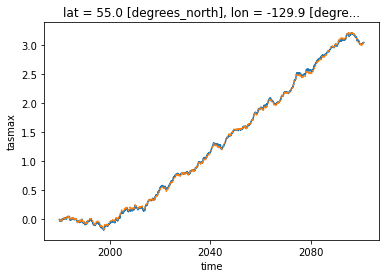

In [16]:
sim= pcat.search(processing_level ='regridded',domain='middle', id = 'CMIP6_ScenarioMIP_INM_INM-CM5-0_ssp370_r1i1p1f1_global').to_dask()
sim = xs.utils.unstack_fill_nan(sim)
sim = sim.isel(lat=150, lon=500)
sim= sim.rolling({'time':365*30}).mean()


scen= pcat.search(processing_level ='final',domain='middle', id = 'CMIP6_ScenarioMIP_INM_INM-CM5-0_ssp370_r1i1p1f1_global').to_dask()
scen = scen.isel(lat=150, lon=500)
scen= scen.rolling({'time':365*30}).mean()

(sim-sim.isel(time=365*30)).tasmax.plot()
(scen-scen.isel(time=365*30)).tasmax.plot(linestyle=':')

# ensemble variability


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


2022-12-20 10:59:36,947 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 10:59:40,446 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 10:59:42,860 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 10:59:45,183 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 10:59:47,429 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 10:59:50,256 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 10:59:53,167 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 10:59:55,793 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 10:59:58,169 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:00:00,901 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:00:03,757 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:00:06,255 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:00:08,885 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:00:12,821 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:00:42,021 - xscen.ensembles - INFO - Creating ensemble with 14 simulations and calculating ensemble_percentiles.

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


2022-12-20 11:00:43,735 - xscen.ensembles - INFO - Creating ensemble with 14 simulations and calculating ensemble_percentiles.

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


2022-12-20 11:05:19,132 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:05:21,694 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:05:24,961 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/c

2022-12-20 11:05:27,297 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:05:29,582 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:05:31,911 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:05:34,254 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:05:37,317 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:05:39,727 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:05:42,225 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:05:44,935 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:05:47,562 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:05:50,034 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:05:53,356 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/c

2022-12-20 11:06:20,799 - xscen.ensembles - INFO - Creating ensemble with 14 simulations and calculating ensemble_percentiles.

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


2022-12-20 11:06:22,506 - xscen.ensembles - INFO - Creating ensemble with 14 simulations and calculating ensemble_percentiles.

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


2022-12-20 11:11:02,144 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:04,552 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:06,776 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:10,827 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:13,485 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:15,994 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:19,030 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:21,479 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:24,109 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:26,464 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:28,966 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:31,543 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:33,832 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/dataset.py:4652: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'ar

2022-12-20 11:11:36,760 - xscen.utils - INFO - Dataset unstacked using /crue/jlavoie/ESPO-G6/extractamno_version/coords/coords_middle_1700x251.nc.


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/xarray/c

2022-12-20 11:12:11,768 - xscen.ensembles - INFO - Creating ensemble with 14 simulations and calculating ensemble_percentiles.

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


2022-12-20 11:12:13,616 - xscen.ensembles - INFO - Creating ensemble with 14 simulations and calculating ensemble_percentiles.


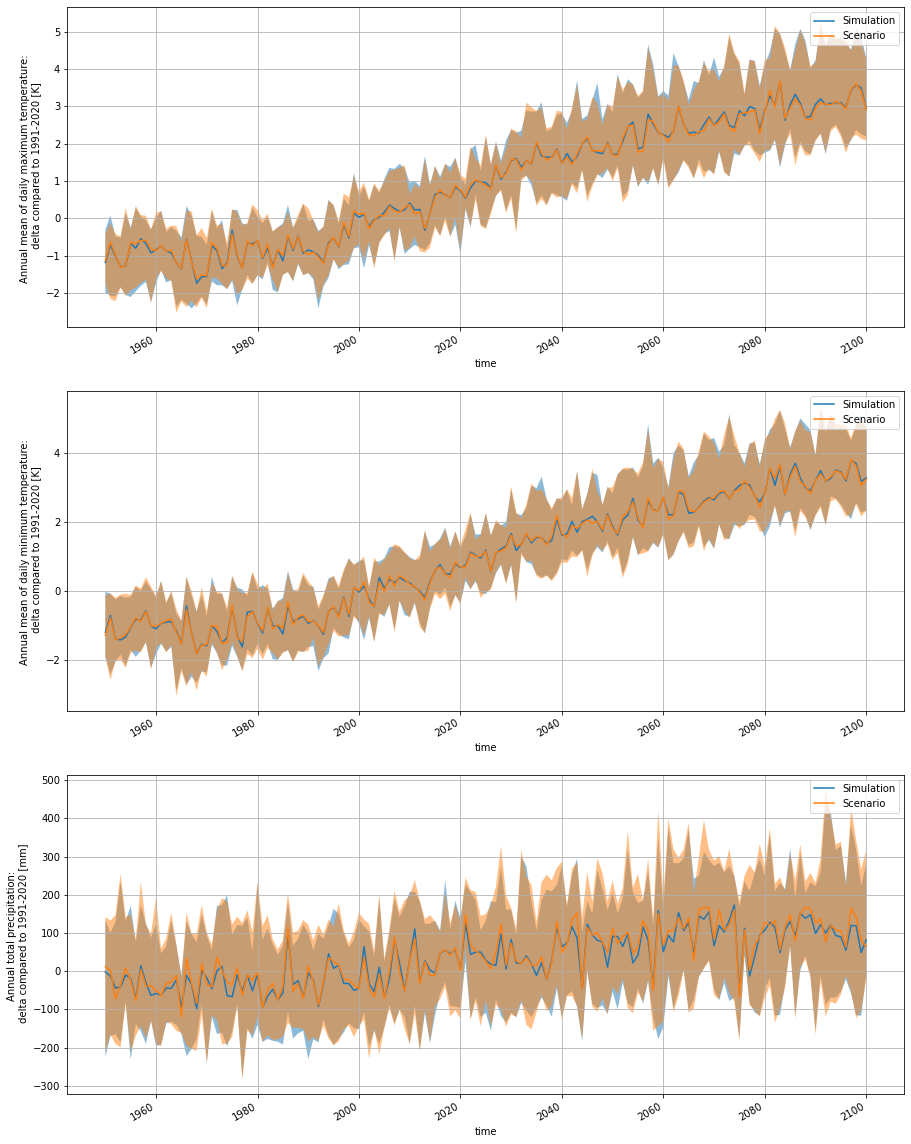

In [25]:
lat= 45.5
lon=-73.5
var = 'tx_mean'
label={'tx_mean':'Annual mean of daily maximum temperature: \n delta compared to 1991-2020 [K]',
       'tn_mean':'Annual mean of daily minimum temperature: \n delta compared to 1991-2020 [K]',
      'prcptot':'Annual total precipitation: \n delta compared to 1991-2020 [mm]'}
func= {'prcptot': 'precip_accumulation',
      'tx_mean':'tx_mean',
      'tn_mean':'tn_mean'}
fig, axs = plt.subplots(3,1, figsize=(15,20))
for i,var in enumerate(['tx_mean', 'tn_mean', 'prcptot']):
    #get variable and compute indicators
    sim_dict = pcat.search(processing_level='regridded', experiment='ssp245', domain ='middle').to_dataset_dict()
    sim_dict= {i:xs.utils.unstack_fill_nan(ds) for i,ds in sim_dict.items()}
    sim_dict= {i: getattr(xc.atmos, func[var])(ds=ds.sel(lat=lat, lon=lon, method='nearest'))for i,ds in sim_dict.items()}
    sim_dict = {i: ds - ds.sel(time=slice('1991', '2020')).mean(dim='time') for i,ds in sim_dict.items()}
    ens_sim = xs.ensembles.ensemble_stats(
                        datasets=sim_dict,
                        statistics={"ensemble_percentiles": {'split': False}},
                        common_attrs_only=False,
                    )[var]


    #get indicators
    scen_dict = pcat.search(processing_level='indicators',
                            variable=var, xrfreq='AS-JAN', experiment='ssp245').to_dataset_dict()
    scen_dict = {i: ds.sel(lat=lat, lon=lon, method='nearest') for i,ds in scen_dict.items()}
    scen_dict = {i: ds - ds.sel(time=slice('1991', '2020')).mean(dim='time') for i,ds in scen_dict.items()}
    ens_scen = xs.ensembles.ensemble_stats(
                        datasets=scen_dict,
                        statistics={"ensemble_percentiles": {'split': False}},
                        common_attrs_only=False,
                    )[var]

    
    axs[i].fill_between(ens_sim.time, ens_sim.sel(percentiles=10), ens_sim.sel(percentiles=90), alpha=0.5)
    ens_sim.sel(percentiles=50).plot(label='Simulation', ax= axs[i])

    axs[i].fill_between(ens_scen.time, ens_scen.sel(percentiles=10), ens_scen.sel(percentiles=90), alpha=0.5)
    ens_scen.sel(percentiles=50).plot(label='Scenario', ax= axs[i])

    axs[i].legend()
    axs[i].grid()
    axs[i].set_title('')
    axs[i].set_ylabel(label[var])
    plt.savefig(f"{CONFIG['paths']['figures']}var.png")

# data

In [ ]:
for level in ['off-diag-ref-prop','off-diag-sim-prop', 'off-diag-sim-meas','off-diag-scen-prop', 'off-diag-scen-meas']:
    hau_dict = pcat.search(domain='Haudenosaunee',
                           processing_level=level
                          ).to_dataset_dict(xarray_open_kwargs={'decode_timedelta':False})
    to_merge= [ds.expand_dims({'realization':[ds.attrs['cat:id']]}) for ds in hau_dict.values()]
    ds = xr.concat(to_merge, dim='realization')
    display(ds)
    ds.to_netcdf(f"{CONFIG['paths']['data']}{level.replace('off-','')}_Haudenosaunee.nc")